100%|██████████| 170M/170M [00:13<00:00, 12.5MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


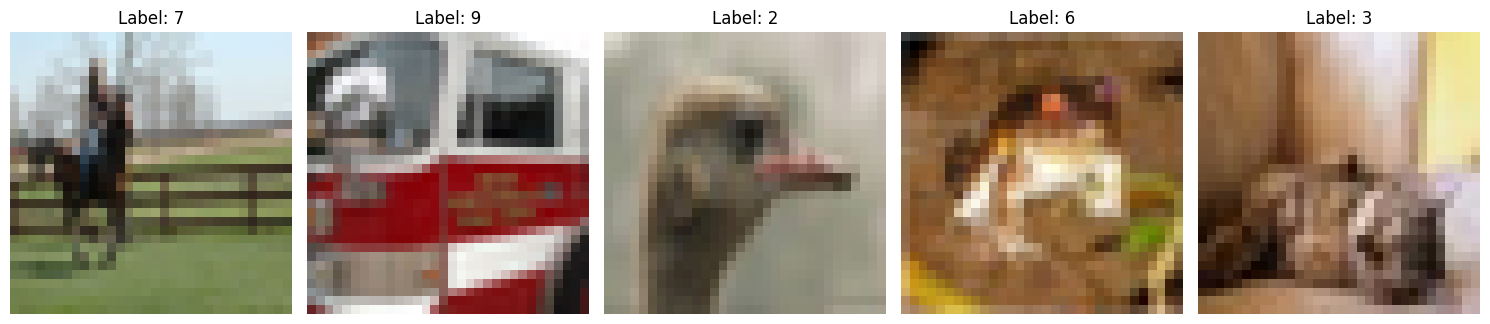

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader, Subset
import torchvision.transforms as transforms
from tqdm import tqdm
import matplotlib.pyplot as plt
import random

# Define the transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize to [-1, 1]
])

# Normalization Importance:
# Improves model training stability and performance.
# Speeds up convergence by centering inputs around zero.
# Works well with activation functions like tanh and ReLU.

# Load the CIFAR-10 dataset
train_dataset = CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = CIFAR10(root='./data', train=False, download=True, transform=transform)

# Subset the dataset to 2500 examples
train_dataset = Subset(train_dataset, range(2500))
test_dataset = Subset(test_dataset, range(500))

# Visualize 5 random images
f, grid = plt.subplots(1, 5, figsize=(15, 5))
for i in range(5):
    idx = random.randint(0, 2499)
    # Convert tensor back to image for display
    image, label = train_dataset[idx]
    image = image.permute(1, 2, 0)  # Convert from [C, H, W] to [H, W, C]
    image = (image * 0.5) + 0.5  # Unnormalize to [0, 1]
    grid[i].imshow(image.numpy())
    grid[i].axis('off')
    grid[i].set_title(f"Label: {label}")

plt.tight_layout()
plt.show()

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


In [ ]:
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        # First convolutional layer: 6 filters, kernel size 5x5
        self.conv1 = nn.Conv2d(3, 6, kernel_size=5, stride=1, padding=0)
        self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2)  # First pooling layer

        # Second convolutional layer: 16 filters, kernel size 5x5
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0)
        self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2)  # Second pooling layer

        # Fully connected layers
        self.fc1 = nn.Linear(16 * 5 * 5, 120)  # Input: flattened feature maps, Output: 120 units
        self.fc2 = nn.Linear(120, 84)  # Output: 84 units
        self.fc3 = nn.Linear(84, 10)  # Output: 10 units (CIFAR-10 classes)

    def forward(self, x):
        # Forward pass through convolutional and pooling layers
        x = torch.relu(self.conv1(x))  # Conv1 + ReLU
        x = self.pool1(x)  # Pooling1
        x = torch.relu(self.conv2(x))  # Conv2 + ReLU
        x = self.pool2(x)  # Pooling2

        # Flatten the tensor
        x = x.view(-1, 16 * 5 * 5)

        # Fully connected layers
        x = torch.relu(self.fc1(x))  # FC1 + ReLU
        x = torch.relu(self.fc2(x))  # FC2 + ReLU
        x = self.fc3(x)  # Output layer
        return x

# Initialize the model, loss function, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LeNet5().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


# Store metrics
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training loop with metrics logging
epochs = 10
for epoch in range(epochs):
    # Training Phase
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Update metrics
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

    train_accuracy = correct_train / total_train
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation Phase
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)

    val_accuracy = correct_val / total_val
    val_loss = val_loss / len(test_loader)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    # Print epoch results
    print(f"Epoch {epoch + 1}/{epochs}")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

Epoch 1/10
Train Loss: 2.2317, Train Accuracy: 0.1720, Val Loss: 2.1511, Val Accuracy: 0.2280
Epoch 2/10
Train Loss: 2.0610, Train Accuracy: 0.2616, Val Loss: 2.0200, Val Accuracy: 0.2760
Epoch 3/10
Train Loss: 1.9774, Train Accuracy: 0.2816, Val Loss: 1.9612, Val Accuracy: 0.2960
Epoch 4/10
Train Loss: 1.8693, Train Accuracy: 0.3176, Val Loss: 1.8735, Val Accuracy: 0.3200
Epoch 5/10
Train Loss: 1.8185, Train Accuracy: 0.3420, Val Loss: 1.8527, Val Accuracy: 0.3300
Epoch 6/10
Train Loss: 1.7795, Train Accuracy: 0.3592, Val Loss: 1.8428, Val Accuracy: 0.3580
Epoch 7/10
Train Loss: 1.7594, Train Accuracy: 0.3592, Val Loss: 1.7572, Val Accuracy: 0.3560
Epoch 8/10
Train Loss: 1.6570, Train Accuracy: 0.3832, Val Loss: 1.7467, Val Accuracy: 0.3700
Epoch 9/10
Train Loss: 1.6256, Train Accuracy: 0.4140, Val Loss: 1.7266, Val Accuracy: 0.3980
Epoch 10/10
Train Loss: 1.5556, Train Accuracy: 0.4348, Val Loss: 1.7090, Val Accuracy: 0.4020


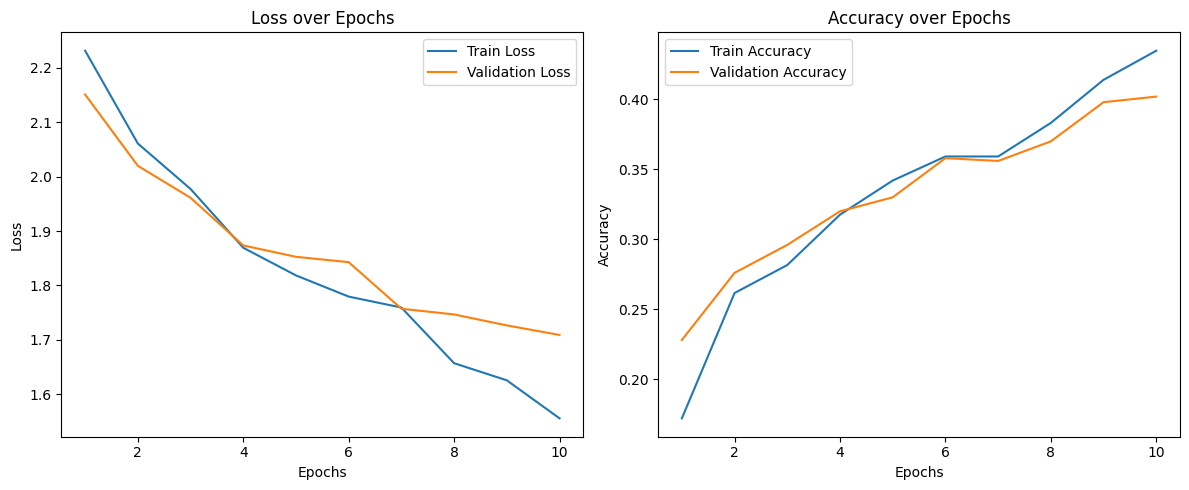

In [ ]:
import matplotlib.pyplot as plt

# Plot Training and Validation Accuracy
plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), train_losses, label="Train Loss")
plt.plot(range(1, epochs + 1), val_losses, label="Validation Loss")
plt.title("Loss over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), train_accuracies, label="Train Accuracy")
plt.plot(range(1, epochs + 1), val_accuracies, label="Validation Accuracy")
plt.title("Accuracy over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

Epoch 1/10
Train Loss (L1): 2.2464, Train Accuracy: 0.1488, Val Loss: 2.1146, Val Accuracy: 0.2320
Epoch 2/10
Train Loss (L1): 2.0696, Train Accuracy: 0.2472, Val Loss: 1.9714, Val Accuracy: 0.2760
Epoch 3/10
Train Loss (L1): 1.9283, Train Accuracy: 0.2976, Val Loss: 1.8833, Val Accuracy: 0.2760
Epoch 4/10
Train Loss (L1): 1.8411, Train Accuracy: 0.3404, Val Loss: 1.8941, Val Accuracy: 0.3160
Epoch 5/10
Train Loss (L1): 1.7991, Train Accuracy: 0.3468, Val Loss: 1.7645, Val Accuracy: 0.3660
Epoch 6/10
Train Loss (L1): 1.7284, Train Accuracy: 0.3744, Val Loss: 1.7949, Val Accuracy: 0.3340
Epoch 7/10
Train Loss (L1): 1.6828, Train Accuracy: 0.3892, Val Loss: 1.7618, Val Accuracy: 0.3400
Epoch 8/10
Train Loss (L1): 1.6391, Train Accuracy: 0.4084, Val Loss: 1.7302, Val Accuracy: 0.3620
Epoch 9/10
Train Loss (L1): 1.5825, Train Accuracy: 0.4328, Val Loss: 1.7321, Val Accuracy: 0.3740
Epoch 10/10
Train Loss (L1): 1.5687, Train Accuracy: 0.4460, Val Loss: 1.6845, Val Accuracy: 0.3480


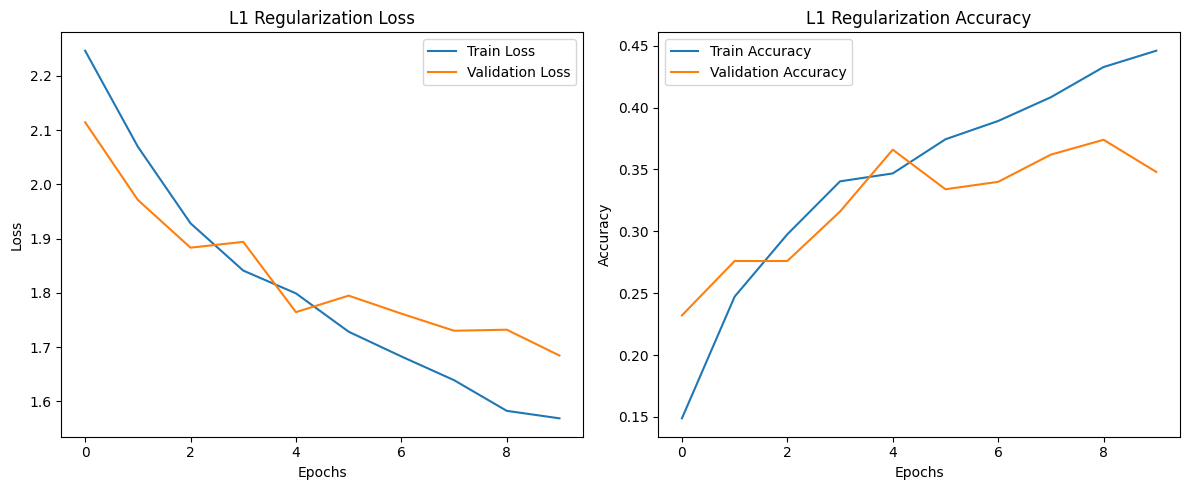

Epoch 1/10
Train Loss (L2): 2.2142, Train Accuracy: 0.1636, Val Loss: 2.0369, Val Accuracy: 0.2280
Epoch 2/10
Train Loss (L2): 2.0027, Train Accuracy: 0.2580, Val Loss: 1.9607, Val Accuracy: 0.2540
Epoch 3/10
Train Loss (L2): 1.9328, Train Accuracy: 0.3016, Val Loss: 1.9534, Val Accuracy: 0.3020
Epoch 4/10
Train Loss (L2): 1.8728, Train Accuracy: 0.3216, Val Loss: 1.8714, Val Accuracy: 0.3340
Epoch 5/10
Train Loss (L2): 1.7994, Train Accuracy: 0.3456, Val Loss: 1.7971, Val Accuracy: 0.3700
Epoch 6/10
Train Loss (L2): 1.7379, Train Accuracy: 0.3748, Val Loss: 1.8040, Val Accuracy: 0.3360
Epoch 7/10
Train Loss (L2): 1.6978, Train Accuracy: 0.3920, Val Loss: 1.7420, Val Accuracy: 0.3500
Epoch 8/10
Train Loss (L2): 1.6505, Train Accuracy: 0.3916, Val Loss: 1.7224, Val Accuracy: 0.3580
Epoch 9/10
Train Loss (L2): 1.6266, Train Accuracy: 0.4180, Val Loss: 1.7685, Val Accuracy: 0.3680
Epoch 10/10
Train Loss (L2): 1.5734, Train Accuracy: 0.4264, Val Loss: 1.7060, Val Accuracy: 0.3800


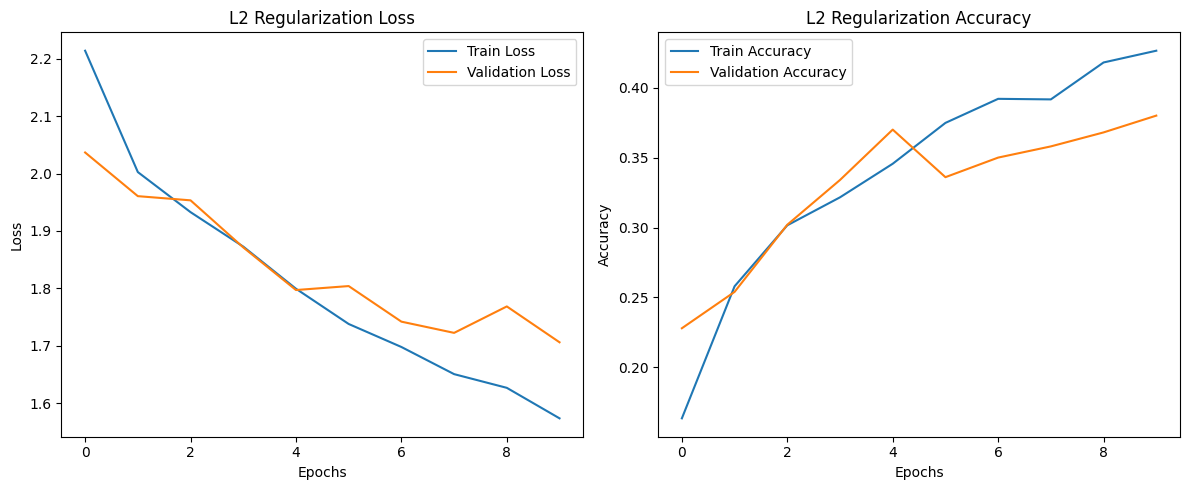

In [ ]:
# Training with L1 Regularization
def train_with_l1_regularization(model, train_loader, test_loader, device, lambda_l1=1e-5, epochs=10):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct_train, total_train = 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Add L1 regularization
            l1_loss = sum(param.abs().sum() for param in model.parameters())
            loss += lambda_l1 * l1_loss

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_train += (predicted == labels).sum().item()
            total_train += labels.size(0)

        train_loss = running_loss / len(train_loader)
        train_accuracy = correct_train / total_train
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # Validation phase
        model.eval()
        val_loss, correct_val, total_val = 0.0, 0, 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                correct_val += (predicted == labels).sum().item()
                total_val += labels.size(0)

        val_loss /= len(test_loader)
        val_accuracy = correct_val / total_val
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f"Epoch {epoch + 1}/{epochs}")
        print(f"Train Loss (L1): {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

    return train_losses, train_accuracies, val_losses, val_accuracies

# Training with L2 Regularization
def train_with_l2_regularization(model, train_loader, test_loader, device, lambda_l2=1e-5, epochs=10):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=lambda_l2)
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct_train, total_train = 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_train += (predicted == labels).sum().item()
            total_train += labels.size(0)

        train_loss = running_loss / len(train_loader)
        train_accuracy = correct_train / total_train
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # Validation phase
        model.eval()
        val_loss, correct_val, total_val = 0.0, 0, 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                correct_val += (predicted == labels).sum().item()
                total_val += labels.size(0)

        val_loss /= len(test_loader)
        val_accuracy = correct_val / total_val
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f"Epoch {epoch + 1}/{epochs}")
        print(f"Train Loss (L2): {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

    return train_losses, train_accuracies, val_losses, val_accuracies

# Plotting function
def plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies, title):
    plt.figure(figsize=(12, 5))

    # Plot losses
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title(f"{title} Loss")
    plt.legend()

    # Plot accuracies
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label="Train Accuracy")
    plt.plot(val_accuracies, label="Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title(f"{title} Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_l1 = LeNet5().to(device)
train_losses, train_accuracies, val_losses, val_accuracies = train_with_l1_regularization(
    model_l1, train_loader, test_loader, device, lambda_l1=1e-5, epochs=10)
plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies, "L1 Regularization")

model_l2 = LeNet5().to(device)
train_losses, train_accuracies, val_losses, val_accuracies = train_with_l2_regularization(
    model_l2, train_loader, test_loader, device, lambda_l2=1e-5, epochs=10)
plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies, "L2 Regularization")


In [ ]:
class LeNet5Flexible(nn.Module):
    def __init__(self, activation_function):
        super(LeNet5Flexible, self).__init__()
        # First convolutional layer: 6 filters, kernel size 5x5
        self.conv1 = nn.Conv2d(3, 6, kernel_size=5, stride=1, padding=0)
        self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2)  # First pooling layer

        # Second convolutional layer: 16 filters, kernel size 5x5
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0)
        self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2)  # Second pooling layer

        # Fully connected layers
        self.fc1 = nn.Linear(16 * 5 * 5, 120)  # Input: flattened feature maps, Output: 120 units
        self.fc2 = nn.Linear(120, 84)  # Output: 84 units
        self.fc3 = nn.Linear(84, 10)  # Output: 10 units (CIFAR-10 classes)

        # Dynamic activation function
        self.activation = activation_function

    def forward(self, x):
        # Forward pass through convolutional and pooling layers
        x = self.activation(self.conv1(x))  # Conv1 + Activation
        x = self.pool1(x)  # Pooling1
        x = self.activation(self.conv2(x))  # Conv2 + Activation
        x = self.pool2(x)  # Pooling2

        # Flatten the tensor
        x = x.view(-1, 16 * 5 * 5)

        # Fully connected layers
        x = self.activation(self.fc1(x))  # FC1 + Activation
        x = self.activation(self.fc2(x))  # FC2 + Activation
        x = self.fc3(x)  # Output layer (no activation here, handled by loss or softmax later)
        return x


Training with Tanh activation function

Epoch 1/10
Train Loss: 2.1041, Train Accuracy: 0.2464, Val Loss: 1.9705, Val Accuracy: 0.3180
Epoch 2/10
Train Loss: 1.9583, Train Accuracy: 0.2956, Val Loss: 1.9254, Val Accuracy: 0.3200
Epoch 3/10
Train Loss: 1.8996, Train Accuracy: 0.3288, Val Loss: 1.9139, Val Accuracy: 0.3020
Epoch 4/10
Train Loss: 1.8400, Train Accuracy: 0.3556, Val Loss: 1.8906, Val Accuracy: 0.3340
Epoch 5/10
Train Loss: 1.7713, Train Accuracy: 0.3704, Val Loss: 1.8743, Val Accuracy: 0.3200
Epoch 6/10
Train Loss: 1.7225, Train Accuracy: 0.3944, Val Loss: 1.8706, Val Accuracy: 0.3300
Epoch 7/10
Train Loss: 1.7004, Train Accuracy: 0.3924, Val Loss: 1.8713, Val Accuracy: 0.3180
Epoch 8/10
Train Loss: 1.6717, Train Accuracy: 0.4080, Val Loss: 1.8446, Val Accuracy: 0.3120
Epoch 9/10
Train Loss: 1.6195, Train Accuracy: 0.4304, Val Loss: 1.8325, Val Accuracy: 0.3380
Epoch 10/10
Train Loss: 1.5889, Train Accuracy: 0.4288, Val Loss: 1.8272, Val Accuracy: 0.3380


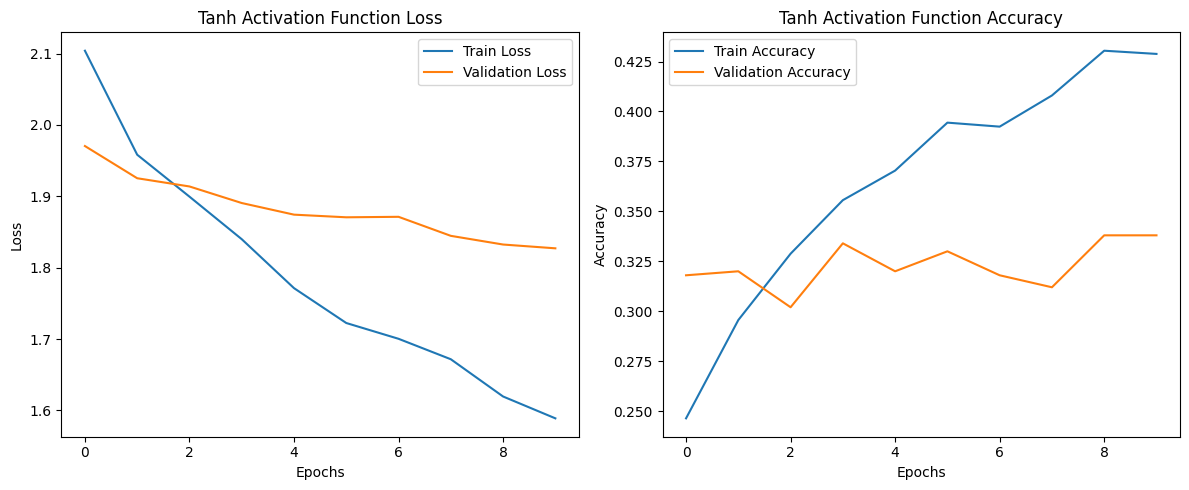


Training with Leaky ReLU activation function

Epoch 1/10
Train Loss: 2.2191, Train Accuracy: 0.1524, Val Loss: 2.0564, Val Accuracy: 0.2600
Epoch 2/10
Train Loss: 2.0086, Train Accuracy: 0.2604, Val Loss: 1.9741, Val Accuracy: 0.2740
Epoch 3/10
Train Loss: 1.9311, Train Accuracy: 0.3060, Val Loss: 1.9326, Val Accuracy: 0.2800
Epoch 4/10
Train Loss: 1.7998, Train Accuracy: 0.3528, Val Loss: 1.8268, Val Accuracy: 0.3200
Epoch 5/10
Train Loss: 1.7424, Train Accuracy: 0.3676, Val Loss: 1.8279, Val Accuracy: 0.3200
Epoch 6/10
Train Loss: 1.7197, Train Accuracy: 0.3660, Val Loss: 1.7717, Val Accuracy: 0.3520
Epoch 7/10
Train Loss: 1.6926, Train Accuracy: 0.3952, Val Loss: 1.7299, Val Accuracy: 0.3780
Epoch 8/10
Train Loss: 1.6263, Train Accuracy: 0.4100, Val Loss: 1.7603, Val Accuracy: 0.3600
Epoch 9/10
Train Loss: 1.5981, Train Accuracy: 0.4128, Val Loss: 1.6739, Val Accuracy: 0.3720
Epoch 10/10
Train Loss: 1.5765, Train Accuracy: 0.4112, Val Loss: 1.7426, Val Accuracy: 0.3800


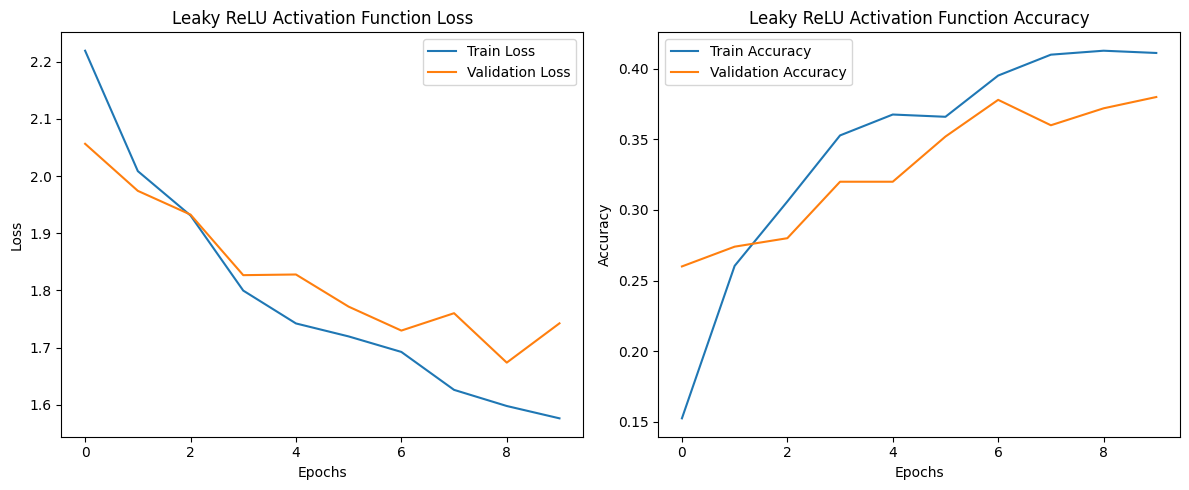


Training with Softmax activation function

Epoch 1/10
Train Loss: 2.3047, Train Accuracy: 0.0944, Val Loss: 2.3010, Val Accuracy: 0.0960
Epoch 2/10
Train Loss: 2.3045, Train Accuracy: 0.0944, Val Loss: 2.3009, Val Accuracy: 0.0960
Epoch 3/10
Train Loss: 2.3040, Train Accuracy: 0.0920, Val Loss: 2.3008, Val Accuracy: 0.1080
Epoch 4/10
Train Loss: 2.3028, Train Accuracy: 0.1020, Val Loss: 2.3012, Val Accuracy: 0.1140
Epoch 5/10
Train Loss: 2.3026, Train Accuracy: 0.1140, Val Loss: 2.3006, Val Accuracy: 0.1960
Epoch 6/10
Train Loss: 2.3014, Train Accuracy: 0.1032, Val Loss: 2.2996, Val Accuracy: 0.1600
Epoch 7/10
Train Loss: 2.2999, Train Accuracy: 0.1688, Val Loss: 2.2978, Val Accuracy: 0.1580
Epoch 8/10
Train Loss: 2.2978, Train Accuracy: 0.1708, Val Loss: 2.2947, Val Accuracy: 0.1540
Epoch 9/10
Train Loss: 2.2932, Train Accuracy: 0.1704, Val Loss: 2.2896, Val Accuracy: 0.1600
Epoch 10/10
Train Loss: 2.2869, Train Accuracy: 0.1644, Val Loss: 2.2832, Val Accuracy: 0.1560


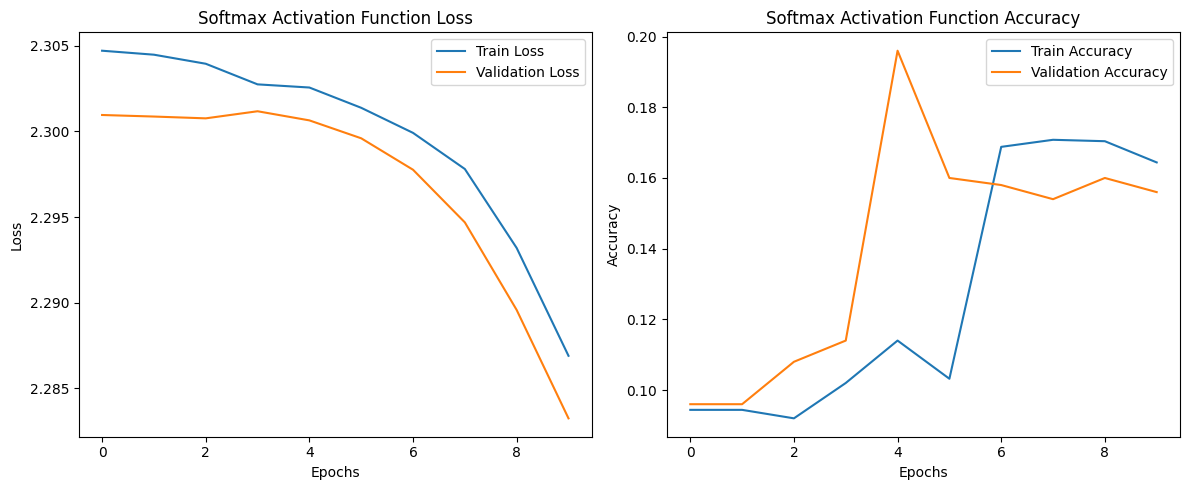

In [ ]:
# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the activation functions
activation_functions = {
    "Tanh": torch.tanh,
    "Leaky ReLU": nn.LeakyReLU(),
    "Softmax": lambda x: nn.functional.softmax(x, dim=1),  # Softmax applied layer-wise
}

def train_and_collect_metrics(model, train_loader, test_loader, device, epochs=10):
    # Define the loss criterion and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Lists to store metrics
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(epochs):
        # Training Phase
        model.train()
        running_loss = 0.0
        correct_train, total_train = 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Accumulate metrics
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_train += (predicted == labels).sum().item()
            total_train += labels.size(0)

        train_losses.append(running_loss / len(train_loader))
        train_accuracies.append(correct_train / total_train)

        # Validation Phase
        model.eval()
        val_loss, correct_val, total_val = 0.0, 0, 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                correct_val += (predicted == labels).sum().item()
                total_val += labels.size(0)

        val_losses.append(val_loss / len(test_loader))
        val_accuracies.append(correct_val / total_val)

        # Print progress
        print(f"Epoch {epoch + 1}/{epochs}")
        print(f"Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accuracies[-1]:.4f}, "
              f"Val Loss: {val_losses[-1]:.4f}, Val Accuracy: {val_accuracies[-1]:.4f}")

    return train_losses, train_accuracies, val_losses, val_accuracies


# Train the model for each activation function
results = {}
for name, activation_function in activation_functions.items():
    print(f"\nTraining with {name} activation function\n")

    # Initialize the model
    model = LeNet5Flexible(activation_function=activation_function).to(device)

    # Train the model (replace train_loader and test_loader with your actual data loaders)
    train_losses, train_accuracies, val_losses, val_accuracies = train_and_collect_metrics(
        model, train_loader, test_loader, device, epochs=10
    )

    # Save the results for analysis
    results[name] = {
        "train_losses": train_losses,
        "val_losses": val_losses,
        "train_accuracies": train_accuracies,
        "val_accuracies": val_accuracies,
    }

    # Plot the metrics for this activation function
    plot_metrics(
        train_losses, val_losses, train_accuracies, val_accuracies, title=f"{name} Activation Function"
    )



Testing Dropout Rate: 0.1

Epoch 1/10
Train Loss: 2.2089, Train Accuracy: 0.1736, Val Loss: 2.0105, Val Accuracy: 0.2860
Epoch 2/10
Train Loss: 2.0117, Train Accuracy: 0.2544, Val Loss: 1.9547, Val Accuracy: 0.2600
Epoch 3/10
Train Loss: 1.9372, Train Accuracy: 0.2888, Val Loss: 1.8768, Val Accuracy: 0.3140
Epoch 4/10
Train Loss: 1.8674, Train Accuracy: 0.3176, Val Loss: 1.8293, Val Accuracy: 0.3380
Epoch 5/10
Train Loss: 1.7901, Train Accuracy: 0.3400, Val Loss: 1.7846, Val Accuracy: 0.3300
Epoch 6/10
Train Loss: 1.7480, Train Accuracy: 0.3528, Val Loss: 1.7788, Val Accuracy: 0.3320
Epoch 7/10
Train Loss: 1.7232, Train Accuracy: 0.3656, Val Loss: 1.7542, Val Accuracy: 0.3260
Epoch 8/10
Train Loss: 1.6794, Train Accuracy: 0.3828, Val Loss: 1.7367, Val Accuracy: 0.3580
Epoch 9/10
Train Loss: 1.6499, Train Accuracy: 0.3940, Val Loss: 1.7175, Val Accuracy: 0.3540
Epoch 10/10
Train Loss: 1.5797, Train Accuracy: 0.4100, Val Loss: 1.6865, Val Accuracy: 0.3580


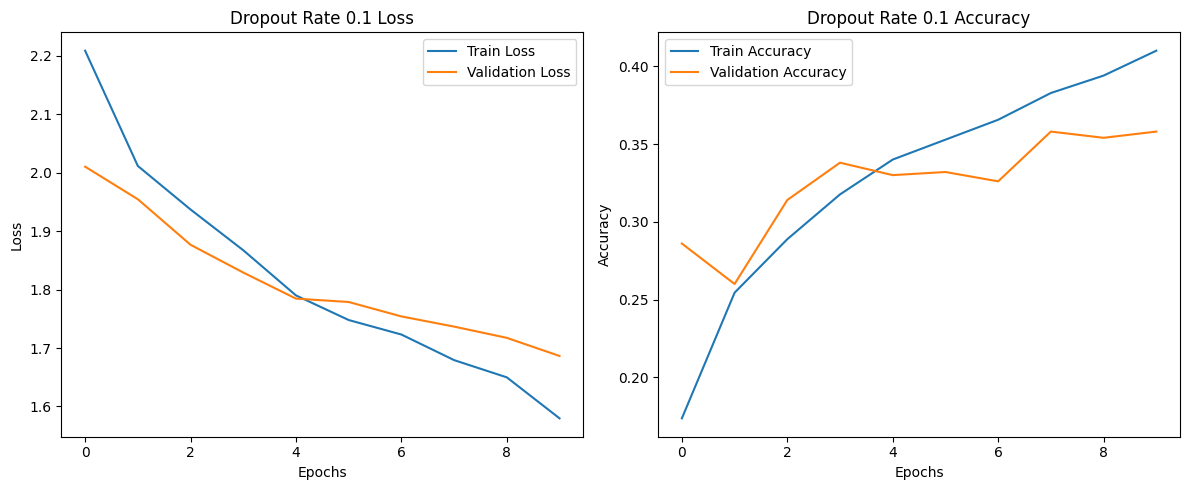


Testing Dropout Rate: 0.2

Epoch 1/10
Train Loss: 2.2339, Train Accuracy: 0.1500, Val Loss: 2.0960, Val Accuracy: 0.2100
Epoch 2/10
Train Loss: 2.0525, Train Accuracy: 0.2404, Val Loss: 1.9809, Val Accuracy: 0.2760
Epoch 3/10
Train Loss: 1.9434, Train Accuracy: 0.2888, Val Loss: 1.9050, Val Accuracy: 0.3320
Epoch 4/10
Train Loss: 1.8934, Train Accuracy: 0.3136, Val Loss: 1.9157, Val Accuracy: 0.2980
Epoch 5/10
Train Loss: 1.8447, Train Accuracy: 0.3360, Val Loss: 1.8612, Val Accuracy: 0.3040
Epoch 6/10
Train Loss: 1.7794, Train Accuracy: 0.3564, Val Loss: 1.8394, Val Accuracy: 0.3320
Epoch 7/10
Train Loss: 1.7896, Train Accuracy: 0.3476, Val Loss: 1.7793, Val Accuracy: 0.3600
Epoch 8/10
Train Loss: 1.7311, Train Accuracy: 0.3624, Val Loss: 1.7844, Val Accuracy: 0.3540
Epoch 9/10
Train Loss: 1.6596, Train Accuracy: 0.3928, Val Loss: 1.7641, Val Accuracy: 0.3500
Epoch 10/10
Train Loss: 1.6707, Train Accuracy: 0.3948, Val Loss: 1.7178, Val Accuracy: 0.3780


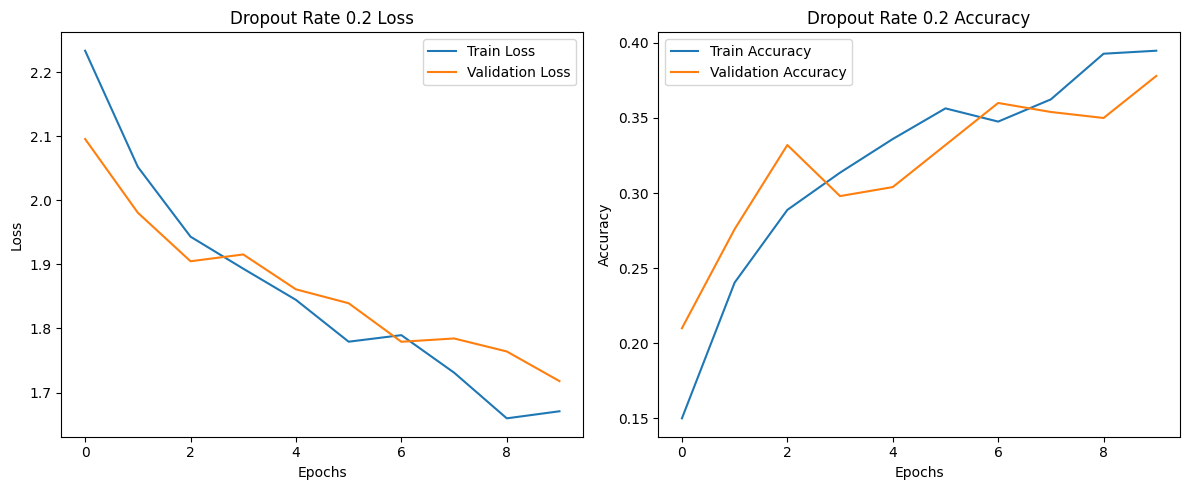


Testing Dropout Rate: 0.5

Epoch 1/10
Train Loss: 2.2720, Train Accuracy: 0.1348, Val Loss: 2.1377, Val Accuracy: 0.2200
Epoch 2/10
Train Loss: 2.1537, Train Accuracy: 0.2024, Val Loss: 2.0447, Val Accuracy: 0.2680
Epoch 3/10
Train Loss: 2.0750, Train Accuracy: 0.2176, Val Loss: 1.9889, Val Accuracy: 0.2740
Epoch 4/10
Train Loss: 2.0417, Train Accuracy: 0.2588, Val Loss: 1.9518, Val Accuracy: 0.2980
Epoch 5/10
Train Loss: 1.9885, Train Accuracy: 0.2448, Val Loss: 1.9230, Val Accuracy: 0.2980
Epoch 6/10
Train Loss: 1.9371, Train Accuracy: 0.2800, Val Loss: 1.8814, Val Accuracy: 0.3320
Epoch 7/10
Train Loss: 1.9158, Train Accuracy: 0.3128, Val Loss: 1.8674, Val Accuracy: 0.3480
Epoch 8/10
Train Loss: 1.9167, Train Accuracy: 0.3068, Val Loss: 1.8576, Val Accuracy: 0.3380
Epoch 9/10
Train Loss: 1.8979, Train Accuracy: 0.3100, Val Loss: 1.8375, Val Accuracy: 0.3460
Epoch 10/10
Train Loss: 1.8592, Train Accuracy: 0.3376, Val Loss: 1.8034, Val Accuracy: 0.3280


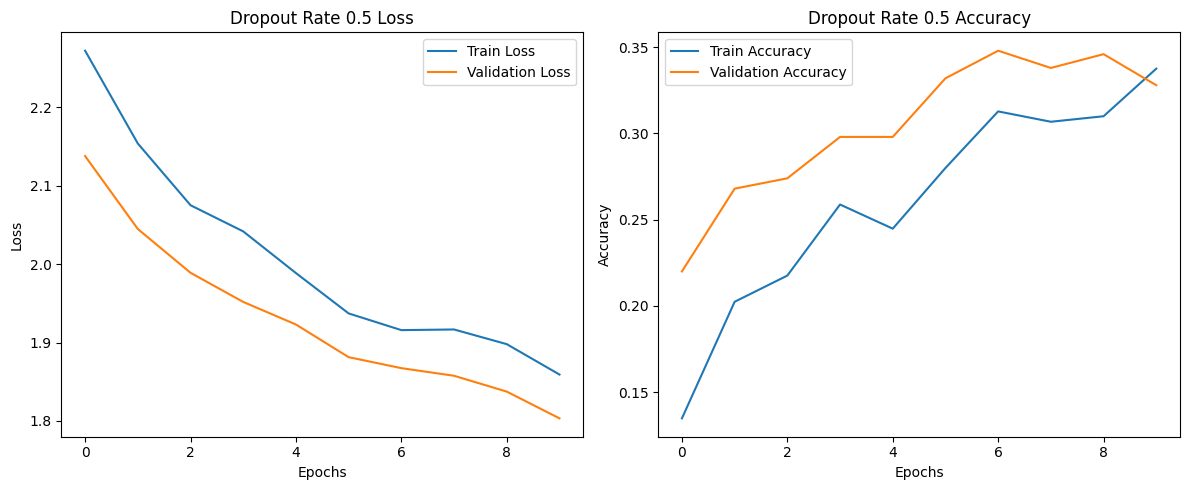

In [ ]:
class LeNet5WithDropout(nn.Module):
    def __init__(self, dropout_rate=0.5):
        super(LeNet5WithDropout, self).__init__()
        # First convolutional layer: 6 filters, kernel size 5x5
        self.conv1 = nn.Conv2d(3, 6, kernel_size=5, stride=1, padding=0)
        self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2)  # First pooling layer

        # Second convolutional layer: 16 filters, kernel size 5x5
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0)
        self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2)  # Second pooling layer

        # Fully connected layers
        self.fc1 = nn.Linear(16 * 5 * 5, 120)  # Input: flattened feature maps, Output: 120 units
        self.fc2 = nn.Linear(120, 84)  # Output: 84 units
        self.fc3 = nn.Linear(84, 10)  # Output: 10 units (CIFAR-10 classes)

        # Dropout
        self.dropout = nn.Dropout(p=dropout_rate)

    def forward(self, x):
        # Forward pass through convolutional and pooling layers
        x = torch.relu(self.conv1(x))  # Conv1 + ReLU
        x = self.pool1(x)  # Pooling1
        x = torch.relu(self.conv2(x))  # Conv2 + ReLU
        x = self.pool2(x)  # Pooling2

        # Flatten the tensor
        x = x.view(-1, 16 * 5 * 5)

        # Fully connected layers with dropout
        x = torch.relu(self.dropout(self.fc1(x)))  # FC1 + ReLU + Dropout
        x = torch.relu(self.dropout(self.fc2(x)))  # FC2 + ReLU + Dropout
        x = self.fc3(x)  # Output layer
        return x
dropout_rates = [0.1, 0.2, 0.5]
results = {}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for rate in dropout_rates:
    print(f"\nTesting Dropout Rate: {rate}\n")
    model = LeNet5WithDropout(dropout_rate=rate).to(device)

    # Train the model (replace train_loader and test_loader with actual data loaders)
    train_losses, train_accuracies, val_losses, val_accuracies = train_and_collect_metrics(
        model, train_loader, test_loader, device, epochs=10
    )

    # Save results
    results[f"Dropout {rate}"] = {
        "train_losses": train_losses,
        "val_losses": val_losses,
        "train_accuracies": train_accuracies,
        "val_accuracies": val_accuracies,
    }

    # Plot metrics for this dropout rate
    plot_metrics(
        train_losses, val_losses, train_accuracies, val_accuracies, title=f"Dropout Rate {rate}"
    )


In [ ]:
class LeNet5WithPooling(nn.Module):
    def __init__(self, pooling_type="avg"):
        super(LeNet5WithPooling, self).__init__()
        # First convolutional layer: 6 filters, kernel size 5x5
        self.conv1 = nn.Conv2d(3, 6, kernel_size=5, stride=1, padding=0)

        # Pooling layer
        if pooling_type == "avg":
            self.pool = nn.AvgPool2d(kernel_size=2, stride=2)
        elif pooling_type == "max":
            self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        elif pooling_type == "min":
            self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # Min pooling simulated with negative MaxPool
            self.invert = True
        else:
            raise ValueError("Invalid pooling_type. Choose from ['avg', 'max', 'min'].")

        # Second convolutional layer: 16 filters, kernel size 5x5
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0)

        # Fully connected layers
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

        # Store pooling type
        self.pooling_type = pooling_type

    def forward(self, x):
        # Apply pooling (invert input/output for min pooling)
        if self.pooling_type == "min":
            x = -self.pool(-torch.relu(self.conv1(x)))  # Conv1 + Min Pool
            x = -self.pool(-torch.relu(self.conv2(x)))  # Conv2 + Min Pool
        else:
            x = self.pool(torch.relu(self.conv1(x)))  # Conv1 + Pool
            x = self.pool(torch.relu(self.conv2(x)))  # Conv2 + Pool

        # Flatten the tensor
        x = x.view(-1, 16 * 5 * 5)

        # Fully connected layers
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)  # Output layer
        return x



Testing avg pooling

Epoch 1/10
Train Loss: 2.2133, Train Accuracy: 0.1680, Val Loss: 2.0666, Val Accuracy: 0.2700
Epoch 2/10
Train Loss: 2.0093, Train Accuracy: 0.2572, Val Loss: 1.9656, Val Accuracy: 0.2800
Epoch 3/10
Train Loss: 1.9139, Train Accuracy: 0.2888, Val Loss: 1.9335, Val Accuracy: 0.2940
Epoch 4/10
Train Loss: 1.8651, Train Accuracy: 0.3156, Val Loss: 1.8550, Val Accuracy: 0.3100
Epoch 5/10
Train Loss: 1.7885, Train Accuracy: 0.3428, Val Loss: 1.8245, Val Accuracy: 0.3380
Epoch 6/10
Train Loss: 1.7431, Train Accuracy: 0.3588, Val Loss: 1.8081, Val Accuracy: 0.3240
Epoch 7/10
Train Loss: 1.6945, Train Accuracy: 0.3816, Val Loss: 1.7533, Val Accuracy: 0.3580
Epoch 8/10
Train Loss: 1.6166, Train Accuracy: 0.4056, Val Loss: 1.7132, Val Accuracy: 0.3600
Epoch 9/10
Train Loss: 1.6036, Train Accuracy: 0.4072, Val Loss: 1.6986, Val Accuracy: 0.3860
Epoch 10/10
Train Loss: 1.5718, Train Accuracy: 0.4224, Val Loss: 1.6826, Val Accuracy: 0.3920


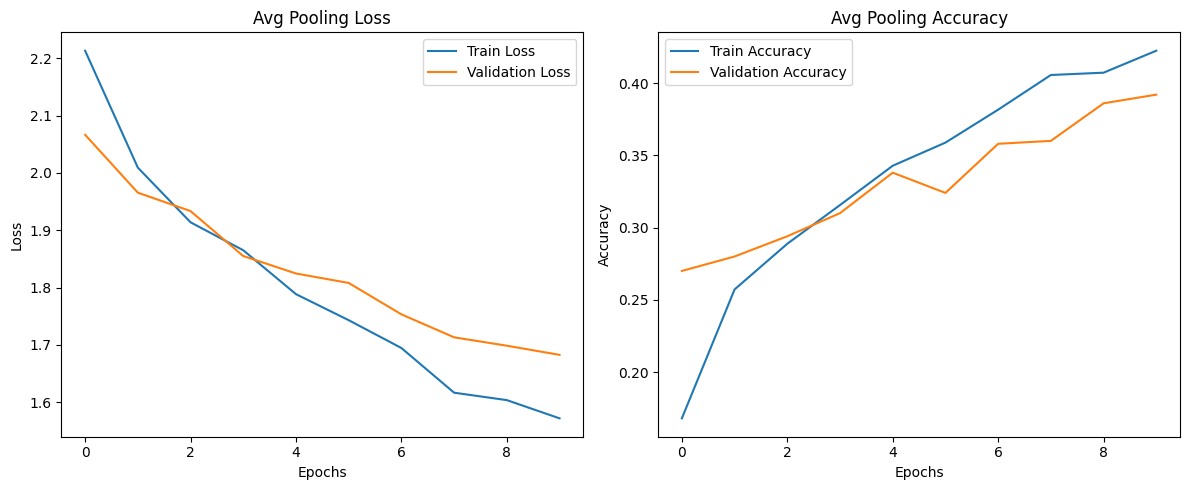


Testing max pooling

Epoch 1/10
Train Loss: 2.2311, Train Accuracy: 0.1508, Val Loss: 2.0998, Val Accuracy: 0.2600
Epoch 2/10
Train Loss: 1.9684, Train Accuracy: 0.2680, Val Loss: 1.9482, Val Accuracy: 0.2940
Epoch 3/10
Train Loss: 1.8720, Train Accuracy: 0.3024, Val Loss: 1.8684, Val Accuracy: 0.3260
Epoch 4/10
Train Loss: 1.7812, Train Accuracy: 0.3500, Val Loss: 1.8108, Val Accuracy: 0.3640
Epoch 5/10
Train Loss: 1.6904, Train Accuracy: 0.3844, Val Loss: 1.7716, Val Accuracy: 0.3380
Epoch 6/10
Train Loss: 1.6344, Train Accuracy: 0.3948, Val Loss: 1.7273, Val Accuracy: 0.3840
Epoch 7/10
Train Loss: 1.5633, Train Accuracy: 0.4276, Val Loss: 1.7361, Val Accuracy: 0.3560
Epoch 8/10
Train Loss: 1.5737, Train Accuracy: 0.4288, Val Loss: 1.7006, Val Accuracy: 0.3840
Epoch 9/10
Train Loss: 1.5352, Train Accuracy: 0.4584, Val Loss: 1.6722, Val Accuracy: 0.3740
Epoch 10/10
Train Loss: 1.4576, Train Accuracy: 0.4832, Val Loss: 1.6361, Val Accuracy: 0.3940


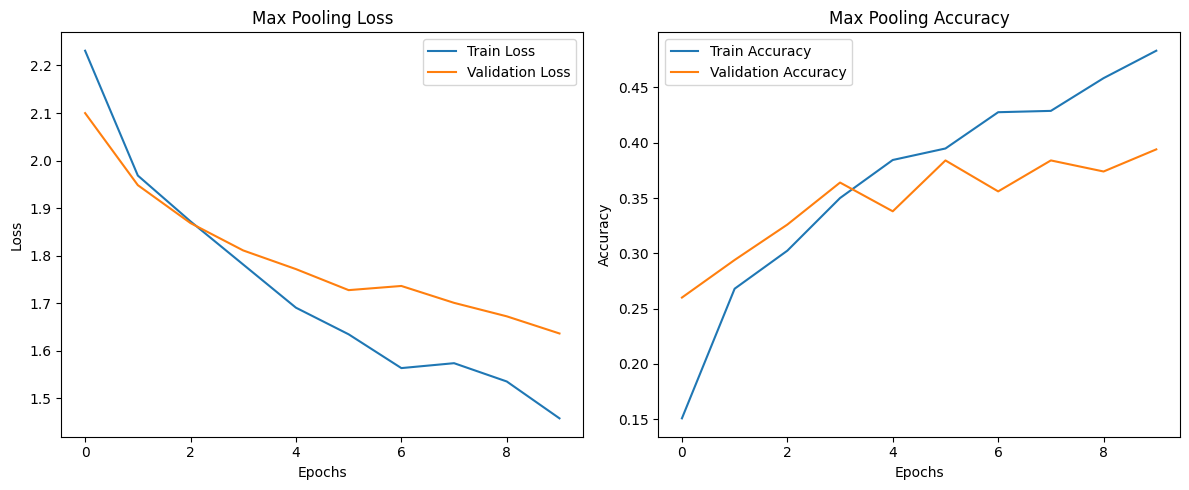


Testing min pooling

Epoch 1/10
Train Loss: 2.2327, Train Accuracy: 0.1544, Val Loss: 2.0737, Val Accuracy: 0.2540
Epoch 2/10
Train Loss: 2.0162, Train Accuracy: 0.2616, Val Loss: 1.9667, Val Accuracy: 0.3100
Epoch 3/10
Train Loss: 1.9277, Train Accuracy: 0.3032, Val Loss: 1.9044, Val Accuracy: 0.3320
Epoch 4/10
Train Loss: 1.8222, Train Accuracy: 0.3424, Val Loss: 1.8440, Val Accuracy: 0.2960
Epoch 5/10
Train Loss: 1.7470, Train Accuracy: 0.3556, Val Loss: 1.8214, Val Accuracy: 0.3020
Epoch 6/10
Train Loss: 1.6994, Train Accuracy: 0.3780, Val Loss: 1.8198, Val Accuracy: 0.3100
Epoch 7/10
Train Loss: 1.6704, Train Accuracy: 0.3928, Val Loss: 1.7611, Val Accuracy: 0.3620
Epoch 8/10
Train Loss: 1.6002, Train Accuracy: 0.4128, Val Loss: 1.7543, Val Accuracy: 0.3600
Epoch 9/10
Train Loss: 1.5439, Train Accuracy: 0.4364, Val Loss: 1.7487, Val Accuracy: 0.3640
Epoch 10/10
Train Loss: 1.5281, Train Accuracy: 0.4560, Val Loss: 1.7183, Val Accuracy: 0.3740


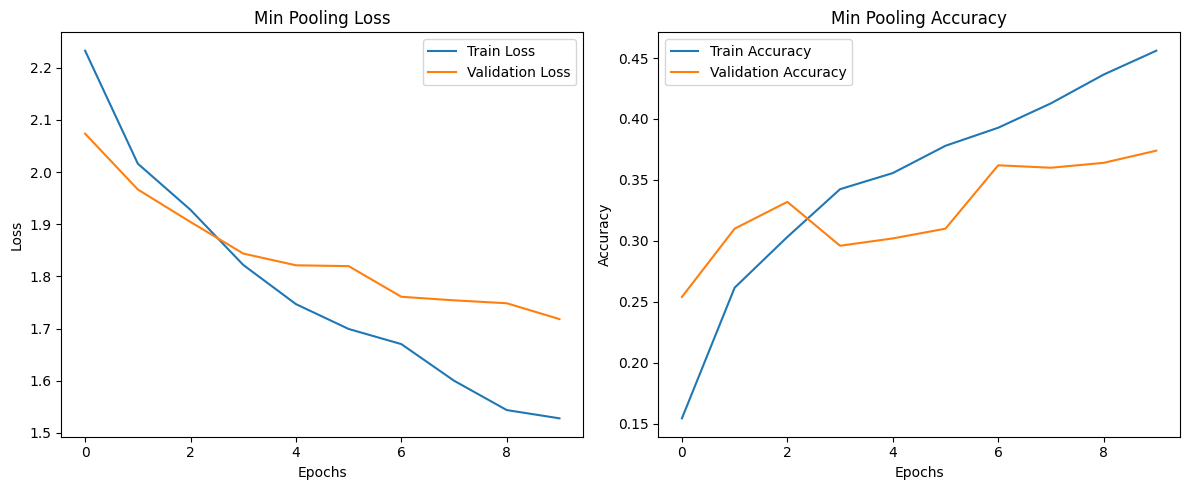

In [ ]:
pooling_types = ["avg", "max", "min"]
results = {}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for pooling_type in pooling_types:
    print(f"\nTesting {pooling_type} pooling\n")
    model = LeNet5WithPooling(pooling_type=pooling_type).to(device)

    # Train the model (replace train_loader and test_loader with actual data loaders)
    train_losses, train_accuracies, val_losses, val_accuracies = train_and_collect_metrics(
        model, train_loader, test_loader, device, epochs=10
    )

    # Save results
    results[f"{pooling_type} pooling"] = {
        "train_losses": train_losses,
        "val_losses": val_losses,
        "train_accuracies": train_accuracies,
        "val_accuracies": val_accuracies,
    }

    # Plot metrics for this pooling type
    plot_metrics(
        train_losses, val_losses, train_accuracies, val_accuracies, title=f"{pooling_type.capitalize()} Pooling"
    )
